In [1]:
import torch
from src.models.video_cav_mae import VideoCAVMAE
from src.dataloader import *
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils

In [2]:
def draw_spectrum(spectrum_np):
    plt.figure(figsize=(10, 6))
    plt.imshow(spectrum_np.T, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Magnitude')
    plt.ylabel('Frequency bins')
    plt.xlabel('Time frames')
    plt.title('Spectrogram')
    plt.show()

def draw_picture(images):
    images = images - images.min()
    images = images / images.max()

    # 使用 torchvision.utils.make_grid 创建一个网格
    grid = torchvision.utils.make_grid(images)

    # 将网格张量转换为numpy数组
    grid_np = grid.numpy().transpose((1, 2, 0))

    # 展示图片
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_np)
    plt.axis('off')  # 不显示坐标轴
    plt.show()

In [3]:
dataset_mean=-5.081
dataset_std=4.4849
im_res = 224
data_val = "/home/zy/lyf/cav-mae/data/valset.csv"

val_audio_conf = {'num_mel_bins': 128, 'target_length': 1024, 'freqm': 0, 'timem': 0, 'mixup': 0,'mode':'eval', 
            'mean': dataset_mean, 'std': dataset_std, 'noise': False, 'im_res': im_res}

val_loader = DataLoader(VideoAudioDataset(data_val, val_audio_conf, stage=1), batch_size=1, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

for i, (audio, frames, labels) in enumerate(val_loader):
    print(audio.shape)
    print(frames.shape)
    print(labels)
    break

Dataset has 79508 samples
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
use dataset mean -5.081 and std 4.485 to normalize the input.
not use noise augmentation
now in eval mode.
now using 224 * 224 image input
torch.Size([1, 1024, 128])
torch.Size([1, 3, 16, 224, 224])
tensor([[1., 0.]])


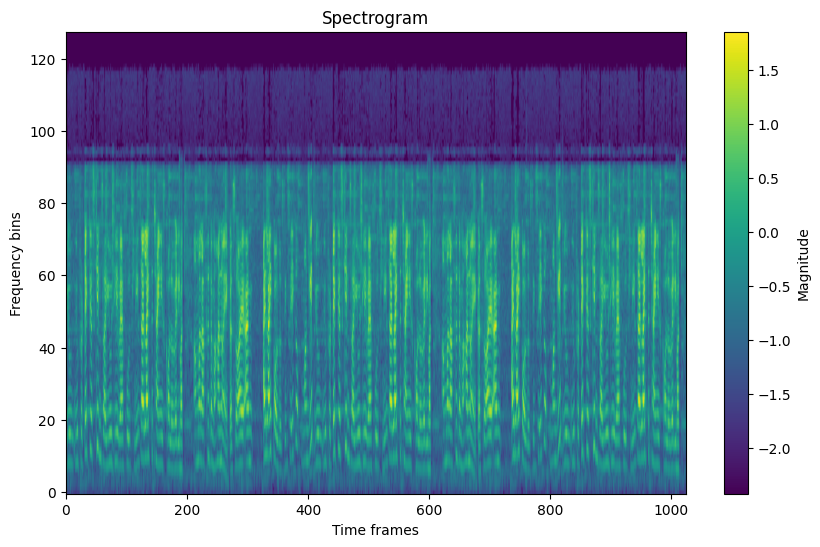

In [4]:
# Plt original spectrum
spectrum_np = audio.squeeze(0).numpy()  # 变为 [1024, 128]
draw_spectrum(spectrum_np)

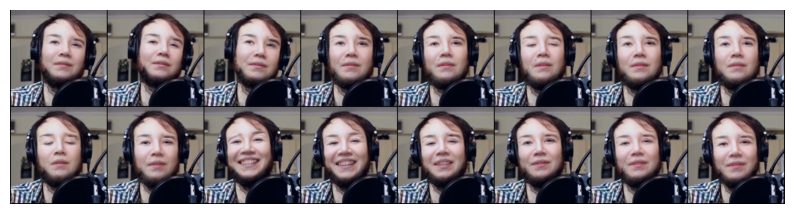

In [5]:
# Plt original frames
frames_ = frames.squeeze(0).transpose(0,1)
draw_picture(frames_)

In [6]:
# Load Reconstruction Model
video_cavmae = VideoCAVMAE()
video_cavmae = torch.nn.DataParallel(video_cavmae)
model = torch.load('/path/to/stage-2.pth', map_location="cpu")

missing, unexpected = video_cavmae.load_state_dict(model)
video_cavmae.to(torch.device('cuda'))
assert len(missing) == 0 and len(unexpected) == 0

In [7]:
total_loss, nce_loss, c_acc, rec_loss_a, rec_loss_v, audio_recon, video_recon = video_cavmae(audio, frames)
audio_recon, video_recon = audio_recon.cpu().detach(), video_recon.cpu().detach()
c_acc.cpu().detach()

/home/zy/miniconda3/envs/cav-mae/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


tensor([1.])

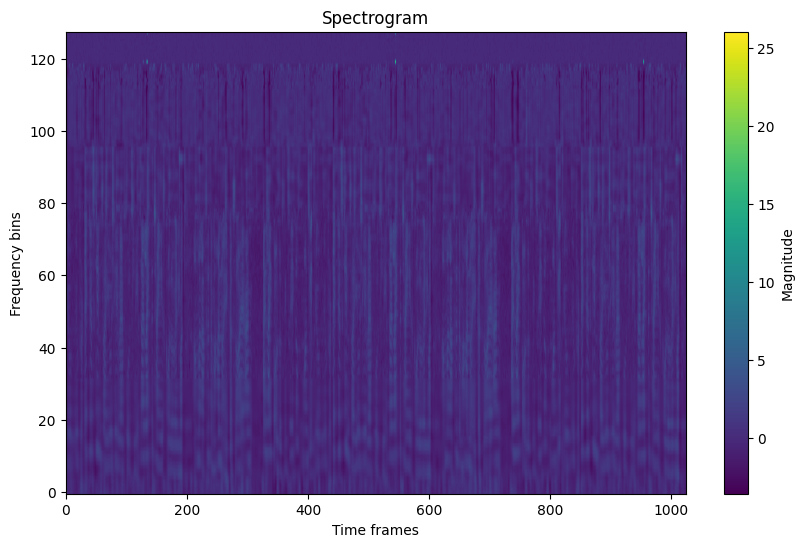

In [8]:
#Plt reconstructed spectrum
spectrum_np = audio_recon.squeeze(0).squeeze(0).transpose(0,1).numpy()  # 变为 [1024, 128]
draw_spectrum(spectrum_np)

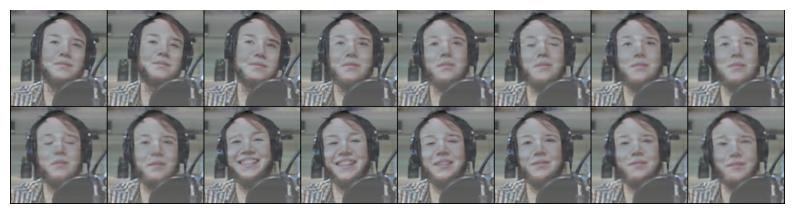

In [9]:
# Plt reconstructed images
frames_ = video_recon.squeeze(0).transpose(0,1)
draw_picture(frames_)